# Temporal Analysis of SIF and XCO2
---

In [97]:
from functools import reduce
import numpy as np
import pandas as pd
import xarray

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy

In [2]:
from dask.distributed import Client
client = Client(n_workers=8, dashboard_address=":8889")
# client = Client()
client

Client Scheduler: tcp://127.0.0.1:37579 Dashboard: http://127.0.0.1:8889/status,Cluster Workers: 8 Cores: 64 Memory: 270.51 GB


In [451]:
client.close()

## Data processing

In [3]:
def prep_sif(ds):
    """Preprocess a SIF Lite file"""
    
    # Drop unused variables
    variable_list = ["Daily_SIF_740nm", "SIF_Uncertainty_740nm", "Quality_Flag", "Longitude", "Latitude", "Delta_Time"]
    ds = ds[variable_list]
    
    # Apply quality filters
    ds["SIF_plus_3sig"] = ds.Daily_SIF_740nm + 3*ds.SIF_Uncertainty_740nm
    ds = ds.where(ds.Quality_Flag != 2, drop=True)
    ds = ds.where(ds.SIF_plus_3sig > 0, drop=True)

    # Format dataset
    dsnew = xarray.Dataset(
        {
            "sif": (["time"], ds.Daily_SIF_740nm),
        },
        coords={
            "lon": (["time"], ds.Longitude),
            "lat": (["time"], ds.Latitude),
            "time": ds.Delta_Time.values
        }
    )
    return dsnew


def prep_xco2(ds):
    """Preprocess an FP Lite file"""
    
    # Drop unused variables
    variable_list = ["xco2", "xco2_quality_flag", "longitude", "latitude", "time"]
    ds = ds[variable_list]
    
    # Apply quality filters
    ds = ds.where(ds.xco2_quality_flag == 0, drop=True)

    # Format dataset
    dsnew = xarray.Dataset(
        {
            "xco2": (["time"], ds.xco2),
        },
        coords={
            "lon": (["time"], ds.longitude),
            "lat": (["time"], ds.latitude),
            "time": ds.time.values
        }
    )
    return dsnew

def regrid(ds):
    """
    Convert dataset to dataframe and assign coordinates to 1-degree grid boxes.
    TODO: make this flexible for different degrees/bands
    """
    # Map lat-lon to 1-degree bins
    lon_bins = np.arange(-180, 181)
    lat_bins = np.arange(-85, 86)
    lon_centers = np.arange(-179.5, 180.5)
    lat_centers = np.arange(-84.5, 85.5)
    
    df = ds.to_dataframe()
    df["lon"] = pd.cut(df.lon, lon_bins, labels=lon_centers).astype(float)
    df["lat"] = pd.cut(df.lat, lat_bins, labels=lat_centers).astype(float)
    
    return df

def aggregate_grid(ds):
    # Map lat-lon to 1-degree bins
    lon_bins = np.arange(-180, 181)
    lat_bins = np.arange(-85, 86)
    lon_centers = np.arange(-179.5, 180.5)
    lat_centers = np.arange(-84.5, 85.5)
    
    df = ds.to_dataframe()
    df["lon"] = pd.cut(df.lon, lon_bins, labels=lon_centers).astype(float)
    df["lat"] = pd.cut(df.lat, lat_bins, labels=lat_centers).astype(float)

    # Group by bins, compute mean, return data array
    return df.groupby(["lon", "lat"]).mean().to_xarray()

In [4]:
# Open datasets for all years
paths_sif = "/data/OCO-2/OCO2_L2_Lite_SIF.10r/*/*.nc4"
paths_xco2 = "/data/OCO-2/OCO2_L2_Lite_FP.10r/*/*.nc4"

DS_sif = xarray.open_mfdataset(paths_sif, preprocess=prep_sif, 
                               parallel=True, engine="h5netcdf")
DS_xco2 = xarray.open_mfdataset(paths_xco2, preprocess=prep_xco2, 
                                parallel=True, engine="h5netcdf")

# NOTE: Date range = 2014-09-06 : 2020-07-31

In [295]:
DS_sif

<xarray.Dataset>
Dimensions:  (time: 241812820)
Coordinates:
    lon      (time) float32 179.95068 179.57373 ... -178.81311 -178.76868
    lat      (time) float32 -18.5755 -16.785889 ... 71.71771 71.712036
  * time     (time) datetime64[ns] 2014-09-06T01:47:19.054687488 ... 2020-07-...
Data variables:
    sif      (time) float32 -0.12462711 0.0866375 ... 0.17045212 0.38776588

## Monthly time series comparison

In [175]:
# Compute monthly climatologies
df_sif = DS_sif.sif.resample(time="1MS").mean(dim="time").to_dataframe()
df_xco2 = DS_xco2.xco2.resample(time="1MS").mean(dim="time").to_dataframe()

# Merge dataframes
df = pd.merge(df_sif, df_xco2, how="outer", on=["time"]).reset_index()
# df["time"] = df.time.dt.strftime("%Y-%m")

df.head()

,time,sif,xco2
0,2014-09-01,0.168572,395.663696
1,2014-10-01,0.124161,396.069519
2,2014-11-01,0.075926,396.865021
3,2014-12-01,0.071579,397.389465
4,2015-01-01,0.080472,397.781097


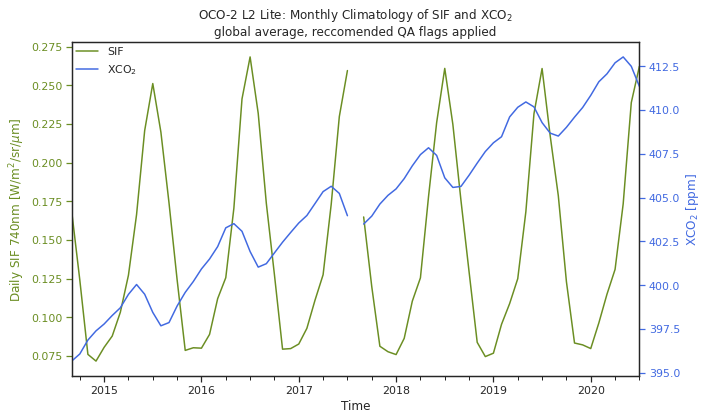

In [176]:
# Plot raw global average climatology
sns.set_style("ticks")
fig, ax1 = plt.subplots(figsize=(10,6))
ax2 = ax1.twinx()

# Set variable colors
sif_color = "olivedrab"
xco2_color = "royalblue"

# Line plots
df.plot(x="time", y="sif", color=sif_color, ax=ax1, legend=False, label="SIF")
df.plot(x="time", y="xco2", color=xco2_color, ax=ax2, legend=False, label="XCO$_2$")

# Customize axes
# plt.locator_params(axis="x", nbins=8)
ax1.tick_params(axis="y", colors=sif_color)
ax2.tick_params(axis="y", colors=xco2_color)
ax1.yaxis.label.set_color(sif_color)
ax2.yaxis.label.set_color(xco2_color)
ax1.figure.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9), frameon=False)

# Add titles
ax1.set_xlabel("Time")
ax1.set_ylabel("Daily SIF 740nm [W/m$^2$/sr/$\mu$m]")
ax2.set_ylabel("XCO$_2$ [ppm]")
ax1.set_title("OCO-2 L2 Lite: Monthly Climatology of SIF and XCO$_2$\n"
              "global average, reccomended QA flags applied")

plt.tight_layout()
# plt.savefig("../plots/monthly_climatology_comparison.png")

### Remove trend to study seasonality of anomalies

In [177]:
# Interpolate missing values
df_full = df.interpolate().set_index("time")

# Fit trends by least squares
X = (df_full.index - df_full.index[0]).days.values.reshape(-1, 1)
trend_sif = LinearRegression().fit(X, df_full.sif).predict(X)
trend_xco2 = LinearRegression().fit(X, df_full.xco2).predict(X)

# Remove trends
df_full["sif_anom"] = df_full.sif - trend_sif
df_full["xco2_anom"] = df_full.xco2 - trend_xco2

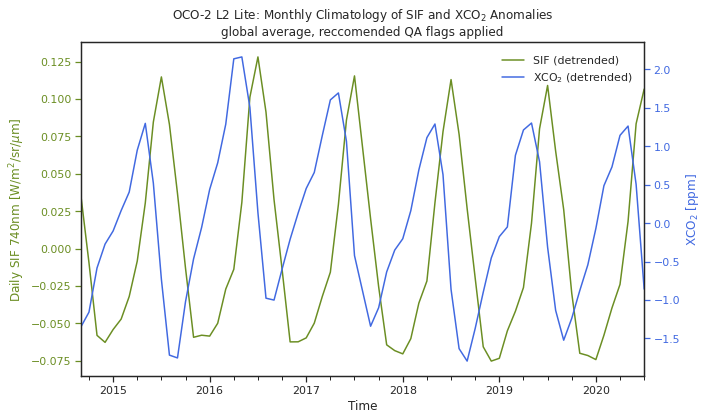

In [178]:
# Plot anomaly climatology
sns.set_style("ticks")
fig, ax1 = plt.subplots(figsize=(10,6))
ax2 = ax1.twinx()

# Set variable colors
sif_color = "olivedrab"
xco2_color = "royalblue"

# Line plots
df_full.plot(y="sif_anom", use_index=True, color=sif_color, ax=ax1, legend=False, label="SIF (detrended)")
df_full.plot(y="xco2_anom", use_index=True, color=xco2_color, ax=ax2, legend=False, label="XCO$_2$ (detrended)")

# Customize axes
# plt.locator_params(axis="x", nbins=8)
ax1.tick_params(axis="y", colors=sif_color)
ax2.tick_params(axis="y", colors=xco2_color)
ax1.yaxis.label.set_color(sif_color)
ax2.yaxis.label.set_color(xco2_color)
ax1.figure.legend(loc="upper right", bbox_to_anchor=(0.9, 0.88), frameon=False)

# Add titles
ax1.set_xlabel("Time")
ax1.set_ylabel("Daily SIF 740nm [W/m$^2$/sr/$\mu$m]")
ax2.set_ylabel("XCO$_2$ [ppm]")
ax1.set_title("OCO-2 L2 Lite: Monthly Climatology of SIF and XCO$_2$ Anomalies\n"
              "global average, reccomended QA flags applied")

plt.tight_layout()
# plt.savefig("../plots/monthly_climatology_detrended.png")

## Lagged analysis

In [24]:
# Lag in months
lag = 3

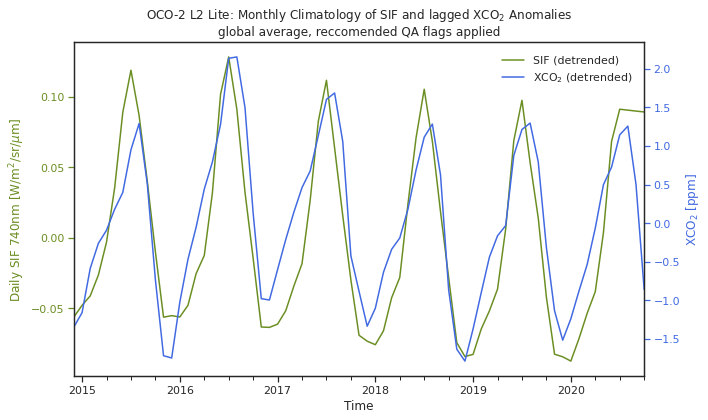

In [26]:
# Lagged climatology
df_sif = DS_sif.sif.resample(time="1MS").mean(dim="time").to_dataframe().reset_index()
df_xco2 = DS_xco2.xco2.resample(time="1MS").mean(dim="time").to_dataframe().reset_index()

df_xco2["time"] = pd.DatetimeIndex( df_xco2["time"] ) + pd.DateOffset(months = lag)

# Merge dataframes
df = pd.merge(df_sif, df_xco2, how="outer", on=["time"])

# Interpolate missing values
df_full = df.interpolate().set_index("time").dropna()

# Fit trends by least squares
X = (df_full.index - df_full.index[0]).days.values.reshape(-1, 1)
trend_sif = LinearRegression().fit(X, df_full.sif).predict(X)
trend_xco2 = LinearRegression().fit(X, df_full.xco2).predict(X)

# Remove trends
df_full["sif_anom"] = df_full.sif - trend_sif
df_full["xco2_anom"] = df_full.xco2 - trend_xco2


sns.set_style("ticks")
fig, ax1 = plt.subplots(figsize=(10,6))
ax2 = ax1.twinx()

# Set variable colors
sif_color = "olivedrab"
xco2_color = "royalblue"

# Line plots
df_full.plot(y="sif_anom", use_index=True, color=sif_color, ax=ax1, legend=False, label="SIF (detrended)")
df_full.plot(y="xco2_anom", use_index=True, color=xco2_color, ax=ax2, legend=False, label="XCO$_2$ (detrended)")

# Customize axes
# plt.locator_params(axis="x", nbins=8)
ax1.tick_params(axis="y", colors=sif_color)
ax2.tick_params(axis="y", colors=xco2_color)
ax1.yaxis.label.set_color(sif_color)
ax2.yaxis.label.set_color(xco2_color)
ax1.figure.legend(loc="upper right", bbox_to_anchor=(0.9, 0.88), frameon=False)

# Add titles
ax1.set_xlabel("Time")
ax1.set_ylabel("Daily SIF 740nm [W/m$^2$/sr/$\mu$m]")
ax2.set_ylabel("XCO$_2$ [ppm]")
ax1.set_title("OCO-2 L2 Lite: Monthly Climatology of SIF and lagged XCO$_2$ Anomalies\n"
              "global average, reccomended QA flags applied")

plt.tight_layout();

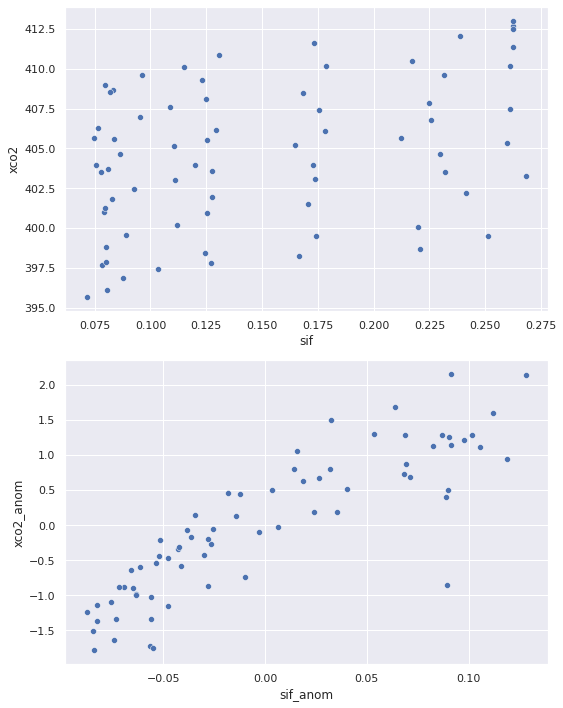

In [27]:
# Scatter plot of all global averages and anomalies
sns.set_theme()
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))

sns.scatterplot(x="sif", y="xco2", data=df_full, ax=ax1)
sns.scatterplot(x="sif_anom", y="xco2_anom", data=df_full, ax=ax2)

plt.tight_layout();

### Look at 1-degree lagged correlation

In [28]:
# Aggregate both datasets to 1-degree monthly averages
DS_sif_grid = DS_sif.resample(time="1MS").map(aggregate_grid)
DS_xco2_grid = DS_xco2.resample(time="1MS").map(aggregate_grid)

In [29]:
# Create data frame joining SIF and lagged XCO2 by coordinates
df_sif = DS_sif_grid.to_dataframe().dropna().reset_index()
df_xco2 = DS_xco2_grid.to_dataframe().dropna().reset_index()

# Apply months lag
df_xco2["time"] = pd.DatetimeIndex( df_xco2["time"] ) + pd.DateOffset(months = lag)

# Perform inner join
df = pd.merge(df_sif, df_xco2, how="inner", on=["lon", "lat", "time"])
df["time"] = df.time.dt.strftime("%Y-%m")
df.sort_values(by="time", inplace=True)

In [30]:
df.head()

,lat,lon,time,sif,xco2
164617,25.5,-100.5,2014-12,0.210840,395.711975
153856,22.5,18.5,2014-12,-0.011871,395.927216
153906,22.5,19.5,2014-12,-0.022469,395.906403
154047,22.5,25.5,2014-12,-0.038195,394.138550
154121,22.5,30.5,2014-12,0.007249,393.447479


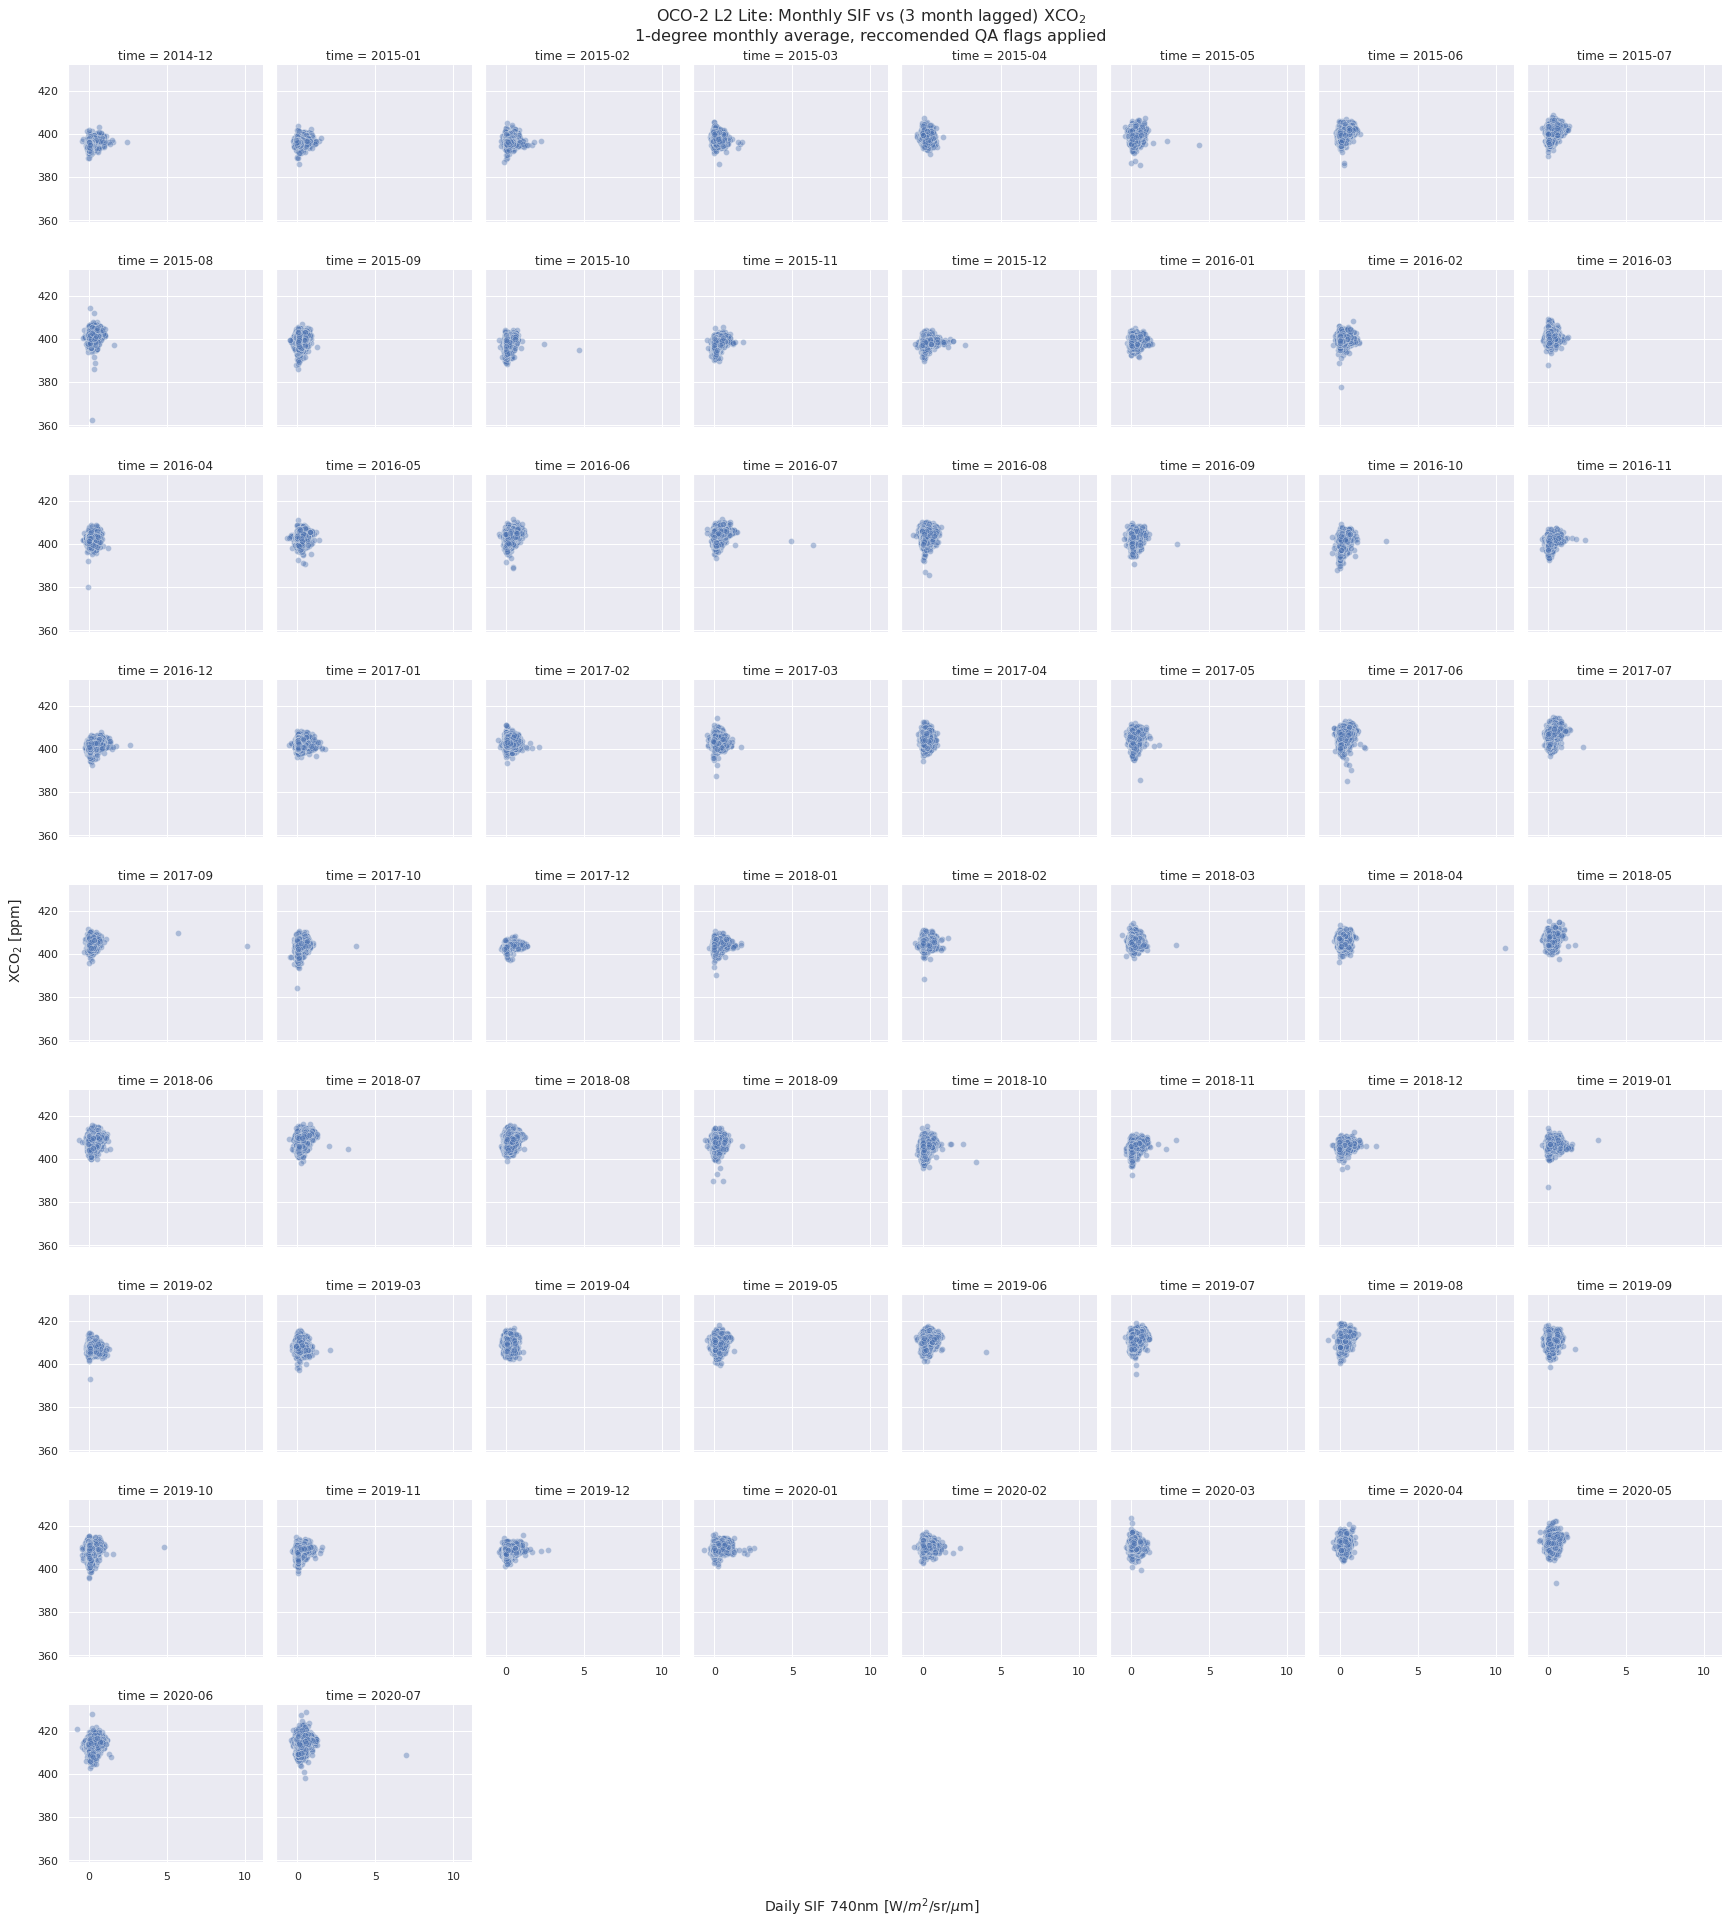

In [32]:
# Make scatter plots faceted by month
sns.set_theme()
g = sns.FacetGrid(df, col="time", col_wrap=8)
g.map(sns.scatterplot, "sif", "xco2", alpha=0.4)

plt.subplots_adjust(top=0.95)
g.fig.suptitle(f"OCO-2 L2 Lite: Monthly SIF vs ({lag} month lagged) XCO$_2$\n" 
               "1-degree monthly average, reccomended QA flags applied",
               size=16)

#this surpresses the x- and y-labels on each axes of the bottom/leftmost column
g.set_axis_labels("", "") 

# overall ylabel
g.fig.text(x=0, y=0.5, 
           verticalalignment="center",
           s="XCO$_2$ [ppm]",
           size=14,
           rotation=90)

#overall xlabel
g.fig.text(x=0.5, y=0, 
           horizontalalignment="center",
           s="Daily SIF 740nm [W/$m^2$/sr/$\mu$m]", 
           size=14)

plt.savefig("../plots/monthly_lagged_scatterplots.png")

## Cross-covariance analysis

In [408]:
def compute_xcov(v1, v2, lag):
    """
    Numba accelerated empirical cross-covariance
    Cressie and Wikle, Eq 5.4, single point.
    Parameters:
        - v1, v2: 1d numpy arrays
        - lag: integer lag in days
    Returns:
        - xcov: float
    """
    # truncate appropriate end of each vector to apply lag
    X = (v1 - np.nanmean(v1))[lag:]
    Y = (v2 - np.nanmean(v2))[:-lag]
    
    # Question: should the nan dates be included in the (T - lag) factor?
#     return np.dot(X, Y) / X.size
#     return np.nansum(X*Y) / X.size
    return np.nansum(X*Y) / X[~np.isnan(X)].size

def compute_xcov_nd(X, Y, lag):
    ## Could maybe improve speed if we can figure out how to broadcast
    ## Also consider avoiding ufunc, instead apply cross_cov to pandas groups
    """
    Numba accelerated empirical cross-covariance
    Cressie and Wikle, Eq 5.4, single point.
    Parameters:
        - v1, v2: n-d numpy arrays
        - lag: integer lag in days
    Returns:
        - xcov: float
    """
    # apply mask for nan values
    v1_m = np.ma.array(v1, mask=np.isnan(v1))
    v2_m = np.ma.array(v2, mask=np.isnan(v2))
    
    # truncate along time dim at appropriate position to apply lag
    X = (v1_m - v1_m.mean(axis=-1, keepdims=True))[:, :, lag:]
    Y = (v2_m - v2_m.mean(axis=-1, keepdims=True))[:, :, :-lag]
    
#     return np.nansum(X*Y, axis=-1, keepdims=True) / X.shape[-1]
    # determine (T-lag) factor for each cell; find the number on non-nan values
    fact = np.count_nonzero(~np.isnan(X), axis=-1)
    
    # compute the inner product along the time dimension
    xcov = np.sum(X*Y, axis=-1) / fact
    
    # return data values with missing entries filled as nan
    return np.ma.filled(xcov.astype(float), np.nan)

    
def apply_cross_covariance(X, Y, lag=0):
    return xarray.apply_ufunc(
        compute_xcov_nd,
        X,
        Y,
        kwargs = {"lag": lag},
        input_core_dims = [["time"], ["time"]],
        dask = "parallelized",
        # vectorize = True, # needed if using 1-d cross-cov func
        output_dtypes = [float],
    )

### Cross covariance for a single 1-degree cell

In [179]:
## Analyze a single cell
time = pd.date_range("2014-09-06", "2020-07-31", freq="1D")

# Setup regional masks
region_sif = (
    (DS_sif.coords["lat"] >= 39)
    & (DS_sif.coords["lat"] < 40)
    & (DS_sif.coords["lon"] <= -89)
    & (DS_sif.coords["lon"] < -90)
)
region_xco2 = (
    (DS_xco2.coords["lat"] >= 39)
    & (DS_xco2.coords["lat"] < 40)
    & (DS_xco2.coords["lon"] <= -89)
    & (DS_xco2.coords["lon"] < -90)
)

# Select values in regional and compute daily average
df_region_sif = DS_sif.sif.where(region_sif, drop=True).resample(time="1D").mean(dim="time").to_dataframe().reset_index()
df_region_xco2 = DS_xco2.xco2.where(region_xco2, drop=True).resample(time="1D").mean(dim="time").to_dataframe().reset_index()

# Apply months lag
# df_region_xco2["time"] = pd.DatetimeIndex( df_region_xco2["time"] ) + pd.DateOffset(months = 2)

# Merge dataframes
frames = [time.to_frame(name="time"), df_region_sif, df_region_xco2]
df_region = reduce(lambda  left,right: pd.merge(left,right, on=["time"], how="outer"), frames).fillna(np.nan)
df_region

,time,sif,xco2
0,2014-09-07,0.419197,392.943848
3,2014-09-10,0.231892,393.473999
4,2014-09-11,0.019689,394.602448
7,2014-09-14,0.354859,393.015381
8,2014-09-15,0.157048,394.473206
...,...,...,...
2148,2020-07-25,0.012569,412.716095
2149,2020-07-26,0.914736,411.605530
2150,2020-07-27,0.191499,412.241913
2151,2020-07-28,0.477579,412.425079


In [385]:
compute_xcov(df_region.sif.values, df_region.xco2.values, lag=90)

0.20890484978170956

### Compute cross covariance for each 1-degree cell and map values

In [426]:
time = pd.date_range("2014-09-06", "2020-07-31", freq="1D").to_frame(name="time")

# Cut datasets to a regular grid and resample to daily averages within each grid cell
df_sif_daily = regrid(DS_sif).groupby(["lon", "lat"]).resample("1D").mean().drop(columns=["lon", "lat"]).reset_index()
df_xco2_daily = regrid(DS_xco2).groupby(["lon", "lat"]).resample("1D").mean().drop(columns=["lon", "lat"]).reset_index()

# Merge dataframes
df_sif_daily_full = pd.merge(time, df_sif_daily, on=["time"], how="outer")
df_xco2_daily_full = pd.merge(time, df_xco2_daily, on=["time"], how="outer")
df_grid_daily = pd.merge(df_sif_daily_full, df_xco2_daily_full, on=["lon", "lat", "time"], how="outer")
df_grid_daily

,time,lon,lat,sif,xco2
0,2014-09-06,-165.5,61.5,0.095413,391.084167
1,2014-09-06,-165.5,62.5,0.020068,391.995697
2,2014-09-06,-164.5,59.5,0.031500,NaN
3,2014-09-06,-164.5,60.5,0.062653,393.286835
4,2014-09-06,-164.5,61.5,0.067781,391.895447
...,...,...,...,...,...
109575185,2020-07-31,179.5,-2.5,NaN,412.345093
109575186,2020-07-31,179.5,-1.5,NaN,412.422943
109575187,2020-07-31,179.5,-0.5,NaN,412.353271
109575188,2020-07-31,179.5,0.5,NaN,412.237396


In [432]:
# Check coverage
df_daily_counts = df_grid_daily.dropna().groupby(["lon", "lat"]).count()
df_daily_counts

time  sif  xco2
lon    lat                   
-179.5 -20.5     3    3     3
       -19.5    61   61    61
       -18.5    35   35    35
       -17.5    30   30    30
       -16.5    41   41    41
...            ...  ...   ...
 179.5  67.5    13   13    13
        68.5    18   18    18
        69.5     6    6     6
        70.5     8    8     8
        71.5    10   10    10

[18046 rows x 3 columns]

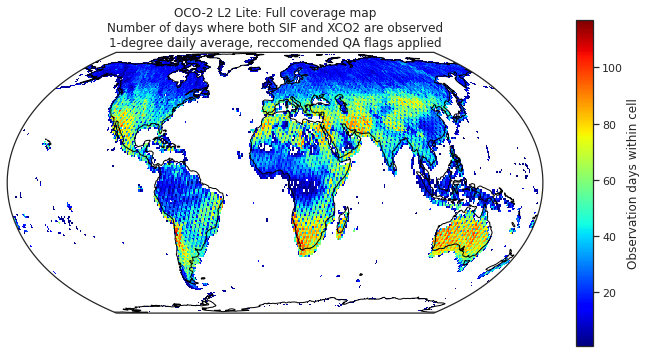

In [437]:
# Coverage map
DS_daily_counts = df_daily_counts.to_xarray()

fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={"projection": ccrs.EqualEarth()})

ax.set_global()
xarray.plot.imshow(DS_daily_counts.sif.T, transform=ccrs.PlateCarree(),
                   cmap="jet", cbar_kwargs={"label": "Observation days within cell"}, ax=ax)
ax.coastlines()
ax.set_title("OCO-2 L2 Lite: Full coverage map\n" 
             "Number of days where both SIF and XCO2 are observed\n"
             "1-degree daily average, reccomended QA flags applied")

plt.savefig("../plots/coverage_map_1degree_daily.png")

In [439]:
# Convert to dataset
DS_grid_daily = df_grid_daily.set_index(["lon", "lat", "time"]).to_xarray()
DS_grid_daily

<xarray.Dataset>
Dimensions:  (lat: 168, lon: 360, time: 2156)
Coordinates:
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat      (lat) float64 -84.5 -83.5 -82.5 -81.5 -80.5 ... 79.5 80.5 81.5 82.5
  * time     (time) datetime64[ns] 2014-09-06 2014-09-07 ... 2020-07-31
Data variables:
    sif      (lon, lat, time) float32 nan nan nan nan nan ... nan nan nan nan
    xco2     (lon, lat, time) float32 nan nan nan nan nan ... nan nan nan nan

In [449]:
# Compute cross covariance for each grid cell (maybe chunk dimensions first)
# X = DS_grid_daily.sif.chunk({"lon": "auto", "lat": "auto"})
# Y = DS_grid_daily.xco2.chunk({"lon": "auto", "lat": "auto"})
X = DS_grid_daily.sif
Y = DS_grid_daily.xco2
DS_xcov = apply_cross_covariance(X, Y, lag=90)

DS_xcov

<xarray.DataArray (lon: 360, lat: 168)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat      (lat) float64 -84.5 -83.5 -82.5 -81.5 -80.5 ... 79.5 80.5 81.5 82.5

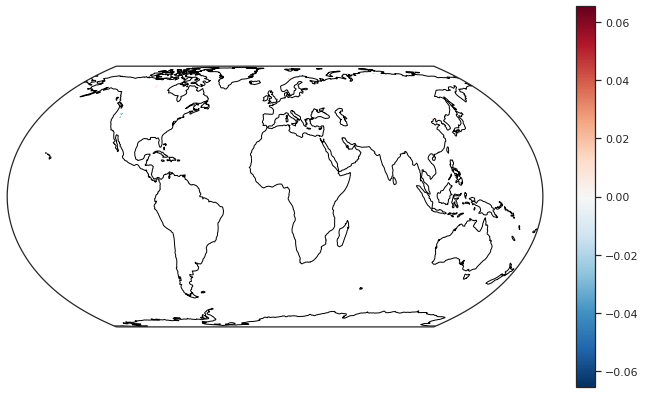

In [450]:
## NOTE: before reporting this, study optimal lag in days, also as about how to handle nans for denominator
fig, ax = plt.subplots(figsize=(12, 7), subplot_kw={"projection": ccrs.EqualEarth()})

ax.set_global()
xarray.plot.imshow(DS_xcov.T, transform=ccrs.PlateCarree(), ax=ax)
ax.coastlines()